In [41]:
#-------------------------------------------------------------------------------
# Name:        module1
# Purpose:
#
# Author:      Saurabh kumar
#
# Created:     3/11/2017
# Copyright:   (c) Saurabh kumar 2017
# Licence:     <your licence>
#-------------------------------------------------------------------------------

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import scipy.io
import math as m
%matplotlib inline
import matplotlib.mlab as mlab
from random import randint
import scipy.io.wavfile
import math
import wave
import warnings
warnings.filterwarnings("ignore")


### 1.4 Load Speech and Noise

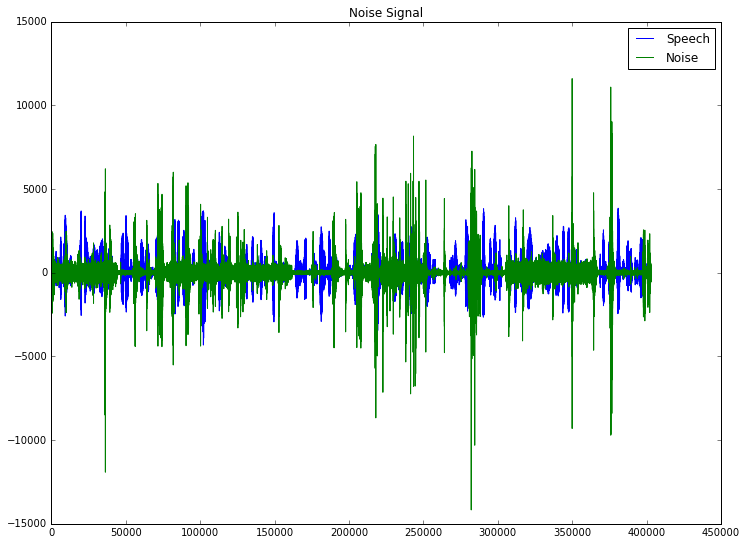

In [20]:
s  = scipy.io.wavfile.read("trs.wav", mmap=False)
s = s[1]
plt.title("Speech Signal")
plt.plot(s, label="Speech")
#plt.legend()
#plt.show()

n  = scipy.io.wavfile.read("trn.wav", mmap=False)
n = n[1]
plt.title("Noise Signal")
plt.plot(n, label="Noise")
plt.legend()
fig_size = []
fig_size.append(12)
fig_size.append(9)
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [21]:
x = s + n
scipy.io.wavfile.write('noisy_signal.wav', 16000, x)

### 1.5 STFT and IBM

In [22]:
def stft(S1):
    N = 1024

    #DFT Matrix Initialization
    F = np.zeros((N, N), dtype=np.complex)

    #Setting Values
    for i in range(0, N):
        for k in range(0, N):
            F[i][k] = math.cos(2 * math.pi * i * k / N) - math.sin(2 * math.pi * i * k / N)*1j

    z = np.zeros(N)
    y = np.zeros(N)
    ptr = 0
    ctr = 0

    S = np.zeros((N, (math.ceil(S1.size/N)*2)))

    #Hann Window
    hann = np.zeros(N)
    for i in range(0, N):
        hann[i] = (0.5 * (1 - math.cos(2*math.pi*i/(N-1))))


    while (ptr < S1.size):
        start = ptr
        end = ptr + N
        if(end > S1.size):
            end = S1.size
        v = end-start
        z[0:int(v)] = S1[int(start):int(end)]
        S[:,ctr] = z * hann
        z = np.zeros(N)
        y = np.zeros(N)
        ptr = ptr + N/2
        ctr = ctr + 1

    #Performing FS and FT
    FS = np.dot(F, S)

    #Ignoring complex conjugate
    FS = FS[0:513, :]
    
    return (FS)

In [23]:
X = np.abs(stft(x))
S = np.abs(stft(s))
N = np.abs(stft(n))
M = np.int16(S > N)
X.shape

(513, 788)

### 1.7 Defining Neural Network with 1 hidden layer and 50 neurons

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: overflow encountered in exp


1471.168062210083


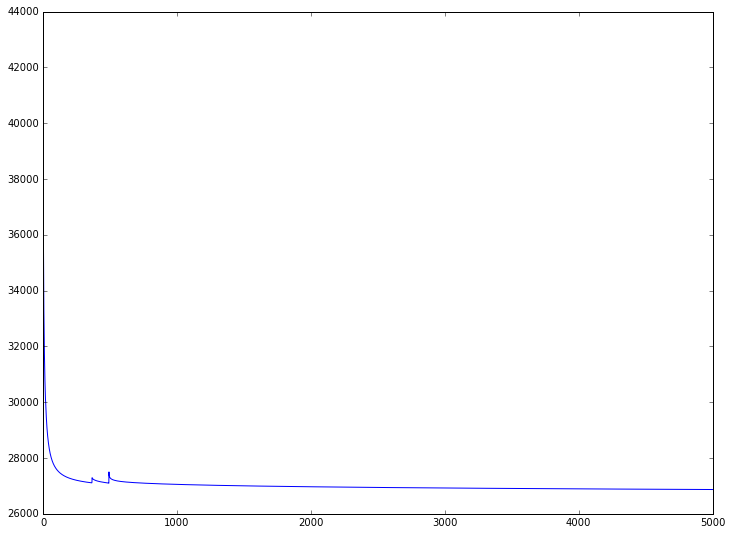

In [27]:
X = X - np.mean(X)
rho = 0.01
A_0 = np.random.uniform(0, 1, (50,514))
A_0 = A_0 - np.mean(A_0)
A_1 = np.random.uniform(0, 1, (513,51))
A_1 = A_1 - np.mean(A_1)
error_sum = 0
num_iteration = 5000
error = np.zeros((513,num_iteration))
import time
t1 = time.time()
for i in range(num_iteration):
    #if(i>500):
        #rho = 0.1
    for j in range(788):
        X_new = np.concatenate((X[:,j],[1]), axis = 0)
        t = A_0.dot(X_new)
        t_sigmoid = sigmoid(t)
        fin_forward = A_1.dot(np.concatenate((t_sigmoid,[1]), axis = 0))
        y_hat = sigmoid(fin_forward)
        e = (M[:,j]-y_hat)**2
        error_sum = error_sum + e
        
        #backpropagation for layer 1
        y_hat_dash = y_hat*(1-y_hat)
        delta_1 = ((y_hat-M[:,j])*y_hat_dash).reshape(513,1)
        delta_A_1 = delta_1.dot(np.concatenate((t_sigmoid,[1]), axis = 0).reshape(51,1).T)
        A_1 = A_1 - rho*delta_A_1
        #backpropagration for layer 0
        t_sigmoid_dash = (t_sigmoid*(1-t_sigmoid)).reshape(50,1)
        delta_0 = (((A_1[:,0:50].T).dot(delta_1))*(t_sigmoid_dash))*(X_new)
        A_0 = A_0 - rho*delta_0
    error[:,i] = 0.5*error_sum
    error_sum=0

t2 = time.time()
print(t2-t1)
plt.plot(np.sum(error, axis=0))
plt.show()

### Error Over Iterations

### 1.8 Applying inverse STFT to get speech signal

In [42]:
N = 1024
overlap = 512
tex = 'tex.wav'
tes = 'tes.wav'
x3 = wave.open(tex, 'r')
noisy = x3.readframes(-1)
noisy = np.fromstring(noisy, 'Int16')
x4 = wave.open(tes, 'r')
clean = x4.readframes(-1)
clean = np.fromstring(clean, 'Int16')

#Hann Window
hann = np.zeros(N)
for i in range(0, N):
    hann[i] = (0.5 * (1 - math.cos(2*math.pi*i/(N-1))))
    
#DFT Matrix Initialization and Inverse DFT
F = np.zeros((N, N), dtype=np.complex)
F_inv = np.zeros((frames, frames), dtype=np.complex)

#Setting Values
for i in range(0, N):
    for k in range(0, N):
        F[i][k] = math.cos(2 * math.pi * i * k / N) - math.sin(2 * math.pi * i * k / N)*1j
        F_inv[i][k] = math.cos(2 * math.pi * i * k /frames) + math.sin(2 * math.pi * i * k / frames)*1j

clean = np.array(clean)
noisy = np.array(noisy)

input_noisy = np.zeros((N, (math.ceil(noisy.size/N)*2)))


#peforming STFT
noisy_hann = np.zeros(N)
frame = 0
index = 0
while (frame < noisy.size):
    f_1 = frame
    f_last = frame + N
    if(f_last > noisy.size):
        f_last = noisy.size
    diff = f_last-f_1
    noisy_hann[0:diff] = noisy[f_1:f_last]
    input_noisy[:,index] = noisy_hann * hann
    noisy_hann = np.zeros(N)
    frame = frame + overlap
    index = index + 1
    

N_test = np.dot(F,input_noisy)


FN_test = np.absolute(N_test[0:513,:])

#IBM test
#M_ft_test = np.int16(FS_test>FN_test)

M_ft_test = np.zeros((513,100))
for i in range(100):
    t = A_0.dot(np.concatenate((FN_test[:,i],[1]), axis = 0))
    t_sigmoid = sigmoid(t)
    fin_forward = A_1.dot(np.concatenate((t_sigmoid,[1]), axis = 0))
    M_ft_test[:,i] = sigmoid(fin_forward)

T = FN_test*M_ft_test
#Inverse STFT to recover signal
T_1 = np.dot(F_inv[:,0:513],T)
T_1 = T_1.real
T_recovery = np.zeros(int(N + (T_1.shape[1]-1)*N/2))

for i in range(T_1.shape[1]):
    T_recovery[int(i*N/2):int(N+i*N/2)] = T_recovery[int(i*N/2):int(N+i*N/2)] + np.transpose(T_1[:, i])
    



clean = np.divide((clean-np.min(clean)), (np.max(clean) - np.min(clean)))
T_recovery = np.divide((T_recovery-np.min(T_recovery)),(np.max(T_recovery) - np.min(T_recovery)) )

numerator = 0
denomenator = 0
for i in range(clean.shape[0]):
    numerator = numerator + T_recovery[i]**2
    denomenator = denomenator + (clean[i]-T_recovery[i])**2

SNR = 10 * math.log10(numerator/denomenator)
print("T_recovery SNR: ", SNR)

T_recovery SNR:  14.695852334598445


# 2 Stereo Matching

### 2.1 Loading Images

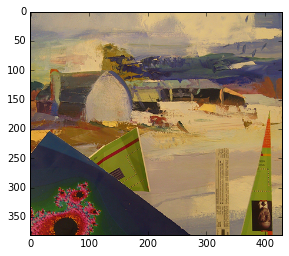

In [2]:
imL = image.imread('im0.ppm')
plt.imshow(imL)
plt.show()

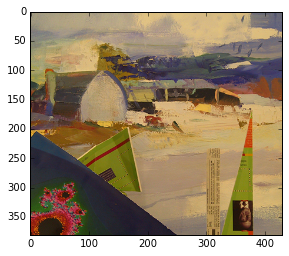

In [3]:
imR = image.imread('im8.ppm')
plt.imshow(imR)
plt.show()

### Disparity Matrix

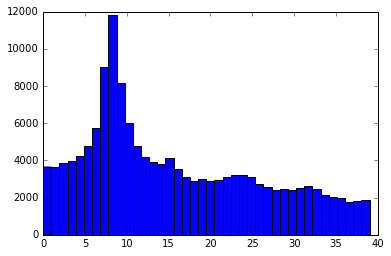

In [4]:
window_metric = 40
disparity_matrix = (np.zeros((381,390))).astype(int)

for i in range(381):
    
    
    for j in range (430-window_metric):
        
        right_pixel = imR[i][j]
        index_distance = 0
        lowest_distance = np.sqrt(np.sum((right_pixel - imL[i][j])**2))
        
        
        for k in range(40):
            left_pixel = imL[i][j+k]
            dist = np.sqrt(np.sum((right_pixel - left_pixel)**2))
            
            if (dist < lowest_distance):
                lowest_distance = dist
                index_distance = k
            
        disparity_matrix[i][j] = index_distance
        
plt.hist(disparity_matrix.ravel(),bins=40)
plt.show()

### GMM

In [5]:
# GMM
# Total number of clusters taken is 3
# Initialize centroid 
depth_map_g = (np.zeros((381,390))).astype(int)
means = np.array([5,18,36])
variance = np.array([2,3,3],dtype=float)
n_clusters = 3
prior = np.array([1/3,1/3,1/3])

def probab(x,u,s):
    part1 = (1/((np.sqrt(2*np.pi)*s)))
    part2 = np.exp(-1*((x-u)**2)/2*s)
    return (part1*part2)

# GMM Code
iterations = 10
posterier_probab = np.zeros((381,390,3))
for iteration in range(iterations):
    n_1 = np.zeros(3)
    d_1 = np.zeros(3)
    n_2 = np.zeros(3)
    

    for i in range(disparity_matrix.shape[0]):

        #last_assignment_index = 0

        for j in range(disparity_matrix.shape[1]):
            
            closest_mean = 0  
            denominator = 0
            # Estimation Step
            for k in range(n_clusters):
            
                denominator+= (prior[k]*probab(disparity_matrix[i][j],means[k],variance[k]))
                #print("numerators:", (prior[k]*probab(disparity_matrix[i][j],means[k],variance[k])))
            #print ("Denominator:",denominator)
            
            for k in range(n_clusters):
            
                    
                posterier_probab[i][j][k] = (prior[k]*probab(disparity_matrix[i][j],means[k],variance[k]))/denominator
            
                # Maximization Calculation
                n_1[k] = n_1[k] + posterier_probab[i][j][k] * disparity_matrix[i][j]
                d_1[k] = d_1[k] + posterier_probab[i][j][k]
                n_2[k] = n_2[k] + posterier_probab[i][j][k] * ((disparity_matrix[i][j] - means[k])**2)
                
                #print (disparity_matrix[i][j],means[k],variance[k])
                #print ((prior[k]*probab(disparity_matrix[i][j],means[k],variance[k])))
                #print ("Denominator:",denominator)
                #print ("Posterior",posterier_probab[i][j][k])
           
    #print ("*****************************Complete****************************************")
    
    #Convergence
    last_mean = np.copy(means)
    
    # Maximization Step
    for k in range(n_clusters):
        
        means[k] = n_1[k]/d_1[k]
        variance[k] = round(d_1[k]/(381*390), 3)
        prior[k] = n_2[k]/d_1[k]
        
    
    #print ("Mean:", means)
    #print ("Variance:", variance)
    #print ("Prior:", prior)
    
    #Convergence Check
    if (np.array_equal(last_mean,means)):
        print ("####################### Convergence Achieved ###########################")
        break

####################### Convergence Achieved ###########################


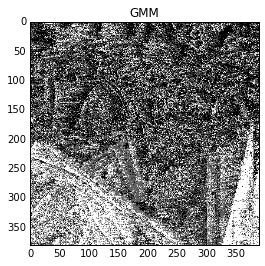

In [6]:
# Forming Depth Map
for i in range(disparity_matrix.shape[0]):

        for j in range(disparity_matrix.shape[1]):
            
            index = np.argmax(posterier_probab[i][j][:])
            depth_map_g[i][j] = means[index]

plt.title("GMM")
plt.imshow(depth_map_g)
plt.gray()
plt.show()   

### 2.2 Gibbs Sampling

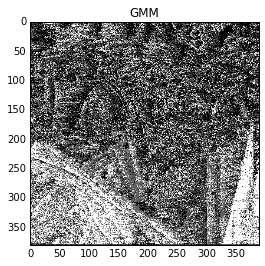

In [13]:

gibbs_probab = np.zeros((disparity_matrix.shape[0],disparity_matrix.shape[1],3))
a = 20
ind = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]])
col1 = posterier_probab[:,0,:]
col2 = posterier_probab[:,-1,:]
row1 = posterier_probab[0,:,:]
row2 = posterier_probab[-1,:,:]

for epoch in range(10):
    for i in range(1,disparity_matrix.shape[0]-1):

        for j in range(1,disparity_matrix.shape[1]-1):

            for k in range(n_clusters):
                P = posterier_probab[i][j][k]

                for l in range(ind.shape[0]):


                    ia = ind[l][0]
                    ib = ind[l][1]
                    clsA = np.argmax(posterier_probab[i][j][:])
                    clsB = np.argmax(posterier_probab[i+ ia][j+ib][:])
                    if (clsA == clsB):
                        p=1
                    else:
                        p = np.exp(-a)
                    P = P*p
                gibbs_probab[i][j][k] = P

            gibbs_probab[i][j][:] = gibbs_probab[i][j][:] / (gibbs_probab[i][j][0] + gibbs_probab[i][j][1] + gibbs_probab[i][j][2]) 

    #print ("Ch1")
    

        
# Forming Depth Map
for i in range(gibbs_probab.shape[0]):

        for j in range(gibbs_probab.shape[1]):
            
            index = np.argmax(gibbs_probab[i][j][:])
            depth_map_g[i][j] = means[index]

plt.title("GMM")
plt.imshow(depth_map_g)
plt.gray()
plt.show() 

# 3 Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising

### Loading Files

In [ ]:
import wave
trs = 'trs.wav'
trn = 'trn.wav'
tex = 'tex.wav'
x1 = wave.open(trs, 'r')
s = x1.readframes(-1)
s = np.fromstring(s, 'Int16')
x2 = wave.open(trn, 'r')
n = x2.readframes(-1)
n = np.fromstring(n, 'Int16')
x3 = wave.open(tex, 'r')
x = x3.readframes(-1)
x = np.fromstring(x, 'Int16')

### 3.1 STFT without mixing

In [ ]:
frames = 1024
overlap = 512

#Creating DFT and inverse DFT
F = np.zeros((frames, frames), dtype=np.complex)
F_inv = np.zeros((frames, frames), dtype=np.complex)
for i in range(frames):
    for k in range(frames):
        #DFT
        F[i][k] = math.cos((2*math.pi*i*k)/frames) - math.sin((2*math.pi*i*k)/frames)*1j
        #Inverse DFT
        F_inv[i][k] = math.cos(2 * math.pi * i * k /frames) + math.sin(2 * math.pi * i * k / frames)*1j

#Hanning Window
hann = np.zeros(frames)
for i in range(frames):
    hann[i] = (0.5 * (1 - math.cos(2*math.pi*i/(frames-1))))


input_S = np.zeros((frames, (math.ceil(s.size/frames)*2)))
input_N = np.zeros((frames, (math.ceil(n.size/frames)*2)))
input_X = np.zeros((frames, (math.ceil(x.size/frames)*2)))
#peforming STFT on s and n
s_hann = np.zeros(frames)
n_hann = np.zeros(frames)
frame = 0
index = 0
while (frame < s.size):
    f_1 = frame
    f_last = frame + frames
    if(f_last > s.size):
        f_last = s.size
    diff = f_last-f_1
    s_hann[0:diff] = s[f_1:f_last]
    n_hann[0:diff] = n[f_1:f_last]
    input_S[:,index] = s_hann * hann
    input_N[:,index] = n_hann * hann
    s_hann = np.zeros(frames)
    n_hann = np.zeros(frames)
    frame = frame + overlap
    index = index + 1
    
#peforming STFT on x
x_hann = np.zeros(frames)
frame = 0
index = 0
while (frame < x.size):
    f_1 = frame
    f_last = frame + frames
    if(f_last > x.size):
        f_last = x.size
    diff = f_last-f_1
    x_hann[0:diff] = x[f_1:f_last]
    input_X[:,index] = x_hann * hann
    x_hann = np.zeros(frames)
    frame = frame + overlap
    index = index + 1
    
S = np.dot(F,input_S)
N = np.dot(F,input_N)
X = np.dot(F,input_X)

FS = np.absolute(S[0:513,:])
FN = np.absolute(N[0:513,:])
FX = np.absolute(X[0:513,:])

### 3.2 Implementing PLSI Algorithm

In [36]:
Bs = np.random.rand(513, 50)
Os = np.random.rand(50, 788)

Bn = np.random.rand(513, 50)
On = np.random.rand(50, 788)
 
vocab1 = np.ones((513,513))
feat1 = np.ones((50,50))
for i in range(1500):
    temp1 = Bs.dot(Os)
    temp2 = np.divide(FS, temp1)
    Bs = Bs*(temp2.dot(Os.T))    
    Bs = np.divide(Bs, (vocab1.dot(Bs)))
    Os = Os*((Bs.T).dot(np.divide(FS, (Bs.dot(Os)))))
    Os = np.divide(Os,(feat1.dot(Os)))
    
    
for i in range(1500):
    temp1 = Bn.dot(On)
    temp2 = np.divide(FN, temp1)
    Bn = Bn*(temp2.dot(On.T))    
    Bn = np.divide(Bn, (vocab1.dot(Bn)))
    On = On*((Bn.T).dot(np.divide(FN, (Bn.dot(Os)))))
    On = np.divide(On,(feat1.dot(On)))
    

B = np.hstack((Bs, Bn))
O = np.random.rand(100,100)
for i in range(1000):
    temp1 = B.dot(O)
    temp2 = np.divide(FX,temp1)
    O = O*((B.T).dot(temp2))
    O = np.divide(O, np.ones(O.shape).dot(O))

#Masking matrix 

M_bar = np.divide(np.dot(Bs,O[0:50,:]),(np.dot(Bs,O[0:50,:]) + np.dot(Bs, O[50:100,:]) +np.spacing(1)))

X_dash = M_bar * X[0:513,:]

#Recovering Signal
X_dash_1 = np.dot(F_inv[:,0:513], X_dash)
X_dash_1 = X_dash_1.real

X_recovered = np.zeros(int(frames + (X_dash_1.shape[1]-1)*frames/2))

for i in range(0, X_dash_1.shape[1]):
    X_recovered[int(i*frames/2):int(frames+i*frames/2)] = X_recovered[int(i*frames/2):int(frames+i*frames/2)] + np.transpose(X_dash_1[:, i])

#X_recovered = np.int16(X_recovered/np.max(np.abs(X_recovered)) * 32767)

max_X_recovered = np.max(X_recovered)
min_X_recovered = np.min(X_recovered)

X_recovered = np.divide((X_recovered-min_X_recovered), (max_X_recovered - min_X_recovered))
outputfile = 'X_recovered.wav'
scipy.io.wavfile.write(outputfile, 16000, X_recovered)   



#Reading clean data
tes = 'data/tes.wav'
x4 = wave.open(tes, 'r')
clean = x4.readframes(-1)
clean = np.fromstring(clean, 'Int16')
max_clean = np.max(clean)
min_clean = np.min(clean)

clean = np.divide((clean-min_clean), (max_clean - min_clean))

numerator = 0
denomenator = 0
for i in range(clean.shape[0]):
    numerator = numerator + X_recovered[i]**2
    denomenator = denomenator + (clean[i]-X_recovered[i])**2

SNR = 10 * math.log10(numerator/denomenator)
print("X_recovered SNR: ", SNR)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:146: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


X_recovered SNR:  15.132759057713013


array([ 9, 12, 18])

# 4 PLSI for Analyzing Twitter Stream

### 4.1 Loading Twitter data

In [32]:
import scipy.io as sio

twitter = sio.loadmat('twitter.mat')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### 4.2 Fetching Columns

In [33]:
xe = twitter['Xte']
xr = twitter['Xtr'] 
Yrmat = twitter['YtrMat']
Yemat = twitter['YteMat']
xr = xr + np.spacing(1)
Bt = np.random.rand(891,50)
Ot = np.random.rand(50,773)

### 4.3 Learning Topics and Weights

In [34]:
topics  = np.ones((891,891))
weights  = np.ones((50,50))

for i in range(1500):
    temp1 = Bt.dot(Ot)
    temp2 = np.divide(xr, temp1)
    Bt = Bt*(temp2.dot(Ot.T))    
    Bt = np.divide(Bt, (topics .dot(Bt)))
    Ot = Ot*((Bt.T).dot(np.divide(xr, (Bt.dot(Ot)))))
    Ot = np.divide(Ot,(weights .dot(Ot)))

### 4.4 Reduce Dimensions

In [35]:
O = np.random.rand(50,193)
for i in range(1000):
    temp1 = Bt.dot(O)
    temp2 = np.divide(xe,temp1)
    O = O*((Bt.T).dot(temp2))
    O = np.divide(O, np.ones((50,50)).dot(O))

### 4.5 Perceptron

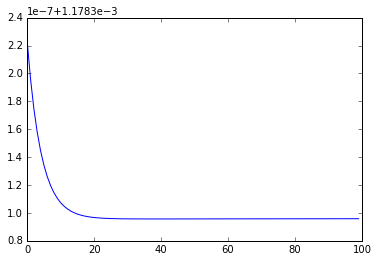

Classification Accuracy %:  51.813471502590666


In [52]:
output_units = 3; 
b = np.random.normal(0,0.01, (output_units,1))
W = np.random.normal(0,0.01,(50,output_units))

A = np.hstack((W.T,b))
A = A - np.mean(A)
rho = 0.0001
error_sum = 0
epoch =  100
error = np.zeros((epoch,1))

for i in range(epoch):
    for j in range(Ot.shape[1]):
        Z = np.concatenate((Ot[:,j], [1]), axis=0)
        z = A.dot(Z)
        y_hat = (sigmoid(z)).reshape(3,1)
        y_hat_sum = np.sum(y_hat, axis=0)
        e = 0
        for k in range(output_units):
            e = e + Yrmat[k,j]*np.log((y_hat[k,:]/y_hat_sum))

        BPE = (z - Yrmat[:,j]).reshape((3,1))       
        
        #Backpropogation
        for k in range(output_units):
            del_A = BPE[k,:] * Z
            A = A - rho*(del_A.T)
            
        error_sum = error_sum + (-e)
    error[i,:] = 1/error_sum
    error_sum=0
    
plt.plot(error)
plt.show()

total_correct = 0
pr = np.zeros((3,1))
for i in range(193):
    Z = np.concatenate((O[:,i], [1]), axis=0)
    z = A.dot(Z)
    y_hat = sigmoid(z).reshape((3,1))
    y_hat_sum = np.sum(y_hat, axis=0)
    e = 0
    for k in range(output_units):
        pr[k,:] = (y_hat[k,:]/y_hat_sum)
 
    if (np.argmax(Yemat [:,i])==np.argmax(pr)):
        total_correct = total_correct + 1
        
        
accuracy = (total_correct/193)*100
print("Classification Accuracy %: ", accuracy)